# Accuracy Assessment

### Psuedocode
- Generate classifier output for entire scene containing qc labels
- Determine exact offset necessary to align with qc labels
- Create output chunk that aligns with qc labels
- generate diff raster of output with qc labels
- generate diff raster of output with burton-johnson labels
- generate histograms
- load band stack
- identify characteristics of pixels that are incorrectly classified
- identify characteristics of images with higher error

In [1]:
import os
import rasterio as rio
import rasterio.windows as wnd
import rasterio.transform as transform
import matplotlib.pyplot as plt
import numpy as np

In [3]:
"""
This function assembles a full scene from the component chunks.
If not all chunks are present, or if an output chunk was ommitted from processing due to a lack of data values,
the area will be filled by a chunk with nodata values

@param string scene_chunk_dir_path: the absolute path to the directory where all chunks for a single scene are stored in
.npy format

@parma rasterio dataset metadata scene_metadata: The dataset.meta of the original scene (most easily generated by
loading a single band of the scene and using its metadata).

@returns np array mosaic: the full-size array with the same dimensions of the original image with width and height rounded
down to the nearest factor of the chunk size (currently hardcoded as 512 * 512)
"""
def mosaic_output(scene_chunk_dir_path, scene_meta):
    columns = (scene_meta['width'] // 512)
    rows = (scene_meta['height'] // 512)
    label_columns = []
    for i in range(rows):
        label_row = []
        for j in range(columns):
            chunk_path = os.path.join(scene_chunk_dir_path, "chunk_{}_{}_output.npy".format(i, j))
            if os.path.exists(chunk_path):
                print("included: {}".format(chunk_path))
                label_row.append(np.load(chunk_path))
            else:
                label_row.append(np.zeros((512, 512), dtype=int))
        label_columns.append(np.concatenate(tuple(label_row), axis=1))
    mosaic = np.concatenate(tuple(label_columns), axis=0)
    return mosaic
                                 

In [15]:
mosaic = mosaic_output(test_output_path, image_meta)

included: /home/dsa/DSA/qc/output/50epoch/chunk_8_13_output.npy
included: /home/dsa/DSA/qc/output/50epoch/chunk_8_14_output.npy


Use the window generated from the intersection of the qc layer with the full band to determine slice values
for the mosaic.

In [16]:
mosaic_qc_chunk = mosaic[rounded_window.row_off:rounded_window.row_off + rounded_window.height,
                         rounded_window.col_off:rounded_window.col_off + rounded_window.width]
print(mosaic_qc_chunk.shape)
print(mosaic.shape)

(333, 333)
(9216, 9216)


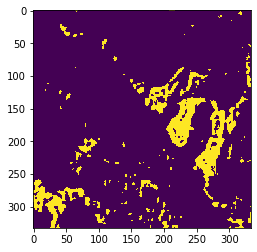

In [17]:
plt.imshow(mosaic_qc_chunk)

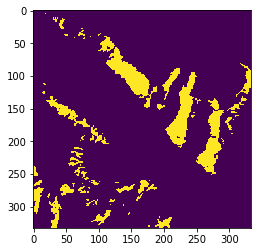

In [18]:
plt.imshow(qc_data)

In [19]:
# !pip install sklearn

In [20]:
from sklearn.metrics import average_precision_score

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
expected = qc_data
print(np.histogram(expected))
actual = mosaic_qc_chunk
print(np.histogram(actual))
color_map = "Dark2"

(array([99304,     0,     0,     0,     0,     0,     0,     0,     0,
       11585]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([99866,     0,     0,     0,     0,     0,     0,     0,     0,
       11023]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


In [23]:
actual = actual * 2
img_diff = expected + actual

In [24]:
diff_hist = np.histogram(img_diff, bins=[0,1,2,3,4])
print(diff_hist)

(array([93888,  5978,  5416,  5607]), array([0, 1, 2, 3, 4]))


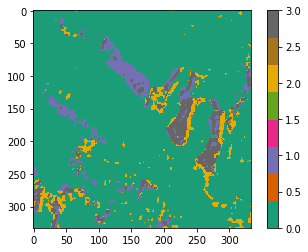

In [25]:
plt.imshow(img_diff, cmap=color_map)
plt.colorbar()

0 = True Negative
1 = False Negative
2 = False Positive
3 = True Positive

In [26]:
def diff_stats(diff_hist):
        total_pixels = diff_hist[0] + diff_hist[1] + diff_hist[2] + diff_hist[3]
        agreement = diff_hist[0] + diff_hist[3]
        disagreement = diff_hist[1] + diff_hist[2]
        summary_stats = "Total: {}\nAgreement: {}\nDisagreement:{}\nNegative: {}\nFalse Negative: {}\n" \
                        "False Positive: {}\nPositive:{}\n\n".format(total_pixels,
                                                                  agreement,
                                                                  disagreement,
                                                                  diff_hist[0], 
                                                                  diff_hist[1], 
                                                                  diff_hist[2],
                                                                  diff_hist[3])
        accuracy = agreement / total_pixels * 100
        error = disagreement / total_pixels * 100
        rock_omission = diff_hist[1] / (diff_hist[1] + diff_hist[3]) * 100
        rock_commission = diff_hist[2] / (diff_hist[2] + diff_hist[3]) * 100
        notrock_omission = diff_hist[2] / (diff_hist[0] + diff_hist[2]) * 100
        notrock_commission = diff_hist[1] / (diff_hist[0] + diff_hist[1]) * 100
        
        error_stats = "Accuracy: {:2.2f}%\nError: {:2.2f}%\n"\
                "Omission Error\n\tRock: {:2.2f}%\n\tNotRock: {:2.2f}%\n"\
                "Commission Error\n\tRock: {:2.2f}%\n\tNotrock: {:2.2f}%\n\n".format(
                                                                accuracy, error,
                                                                rock_omission, notrock_omission,
                                                                rock_commission, notrock_omission)

        rock_producers = diff_hist[3] / (diff_hist[1] + diff_hist[3]) * 100
        notrock_producers = diff_hist[0] / (diff_hist[0] + diff_hist[2]) * 100
        rock_users = diff_hist[3] / (diff_hist[2] + diff_hist[3]) * 100
        notrock_users = diff_hist[0] / (diff_hist[0] + diff_hist[1]) * 100

        accuracy_stats = "Producer's Accuracy\n\tRock: {:2.2f}%\n\tNot Rock: {:2.2f}%\n"\
                "User's Accuracy\n\tRock:{:2.2f}%\n\tNot Rock: {:2.2f}%\n\n".format(rock_producers, notrock_producers,
                                                                  rock_users, notrock_users)
        return summary_stats + error_stats + accuracy_stats




In [27]:
results = diff_stats(diff_hist[0])

In [28]:
print(results)

Total: 110889
Agreement: 99495
Disagreement:11394
Negative: 93888
False Negative: 5978
False Positive: 5416
Positive:5607

Accuracy: 89.72%
Error: 10.28%
Omission Error
	Rock: 51.60%
	NotRock: 5.45%
Commission Error
	Rock: 49.13%
	Notrock: 5.45%

Producer's Accuracy
	Rock: 48.40%
	Not Rock: 94.55%
User's Accuracy
	Rock:50.87%
	Not Rock: 94.01%


